# Floor plan auto-completion dataset

## Import dataset

In [1]:
import os
import pandas as pd
from geopandas import GeoDataFrame as gdf

path = r'C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0'
geometries = pd.read_csv(os.path.join(path, 'geometries.csv'))
geometries = gdf(geometries)
geometries

,apartment_id,site_id,building_id,plan_id,floor_id,unit_id,area_id,unit_usage,entity_type,entity_subtype,geometry,elevation,height
0,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619311.0,RESIDENTIAL,area,BATHROOM,POLYGON ((-2.7337844078265210 4.07980744083215...,0.0,2.6
1,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619303.0,RESIDENTIAL,area,LIVING_ROOM,POLYGON ((5.8278988701887320 7.816876723402971...,0.0,2.6
2,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619322.0,RESIDENTIAL,area,ROOM,POLYGON ((6.7557107205191187 2.413369594812586...,0.0,2.6
3,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619310.0,RESIDENTIAL,area,KITCHEN,POLYGON ((3.5821200013910017 5.140461688341117...,0.0,2.6
4,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619312.0,RESIDENTIAL,area,ROOM,POLYGON ((3.0141380455489282 4.182056855151666...,0.0,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255900,NaN,855,1810,5103,8035,NaN,NaN,PUBLIC,opening,DOOR,POLYGON ((-1.4298320523458550 3.33190316001201...,14.5,2.0
3255901,NaN,855,1810,5103,8035,NaN,NaN,PUBLIC,opening,ENTRANCE_DOOR,POLYGON ((-3.5023200042238898 3.33190316001201...,14.5,2.0
3255902,NaN,855,1810,5103,8035,NaN,NaN,PUBLIC,opening,WINDOW,POLYGON ((0.5283550488528448 5.786336039980051...,15.0,1.9
3255903,NaN,855,1810,5103,8035,NaN,NaN,PUBLIC,opening,WINDOW,POLYGON ((-3.6279253346407394 5.80601415589792...,15.0,1.9


## Meta analysis and filtering

Below shows the distribution of entity subtypes; the logarithmic scale spreads it more conveniently. Obviously, there are frequent occurring subtypes such as WALL, KITCHEN, ROOM, BATHROOM, but also subtypes that do nearly occur (<100 times in the whole dataset) such as TEACHING ROOM, WATER SUPPLY, COUNTER ROOM, ARCADE, RECEPTION ROOM.

In [2]:
TYPES = geometries.groupby(['entity_type']).count().sort_values(by = ['geometry'])['geometry'].to_frame()
SUBTYPES = geometries.groupby(['entity_subtype']).count().sort_values(by = ['geometry'])['geometry'].to_frame()

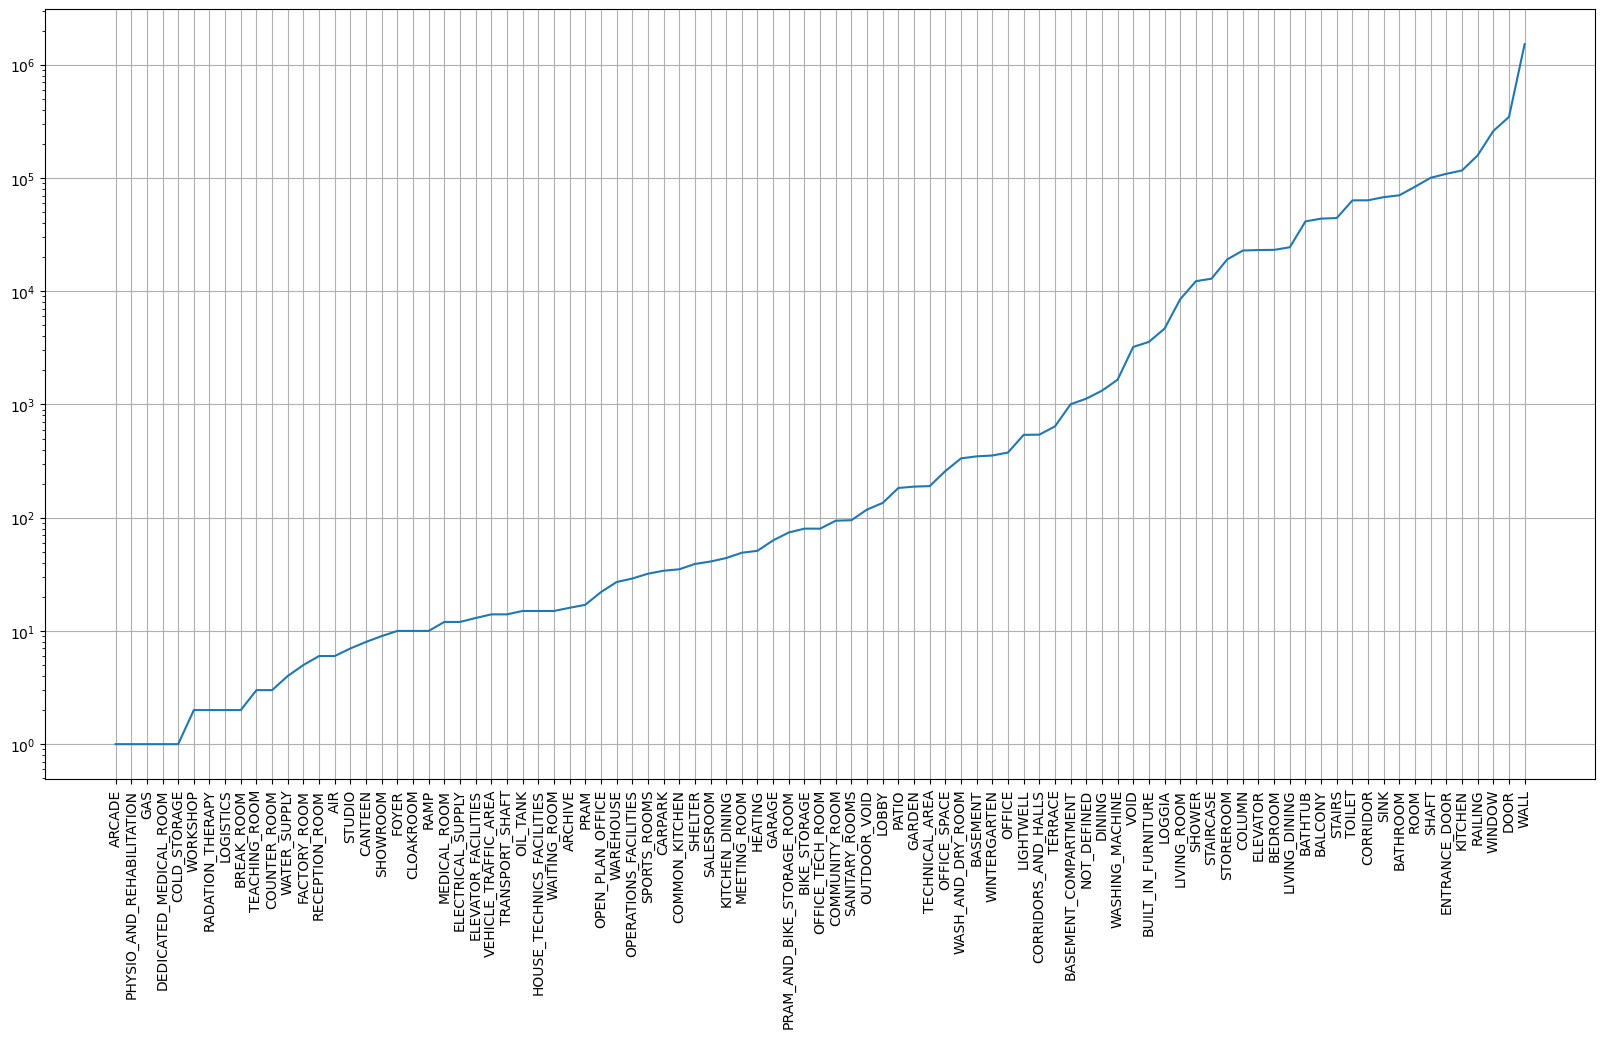

In [3]:
import matplotlib.pyplot as plt

FS = 10
fig, ax = plt.subplots(1,1,figsize=(FS*2, FS))
ax.grid(True)

ax.plot(SUBTYPES)
ax.set_yscale('log') # set to log-scale for interpretability
ax.tick_params(axis='x', labelrotation = 90)

### Filter on residential

Check typologies

In [4]:
TYPOLOGIES = geometries.groupby(['unit_usage']).count().sort_values(by = ['geometry'])['geometry'].to_frame()
TYPOLOGIES

,geometry
unit_usage,
JANITOR,38
PLACEHOLDER,82
COMMERCIAL,16500
PUBLIC,588501
RESIDENTIAL,2650784


Filter the dataset

In [5]:
from utils import SUBTYPES_TO_REMOVE

# filter on residential
temp_geometries = geometries[geometries.unit_usage == "RESIDENTIAL"].reset_index()
valid_floor_ids = set(temp_geometries.floor_id)
residential_geometries = geometries[geometries['floor_id'].isin(valid_floor_ids)].reset_index()

# remove mixtures
wrong_geometries = residential_geometries[residential_geometries['entity_subtype'].isin(set(SUBTYPES_TO_REMOVE))].reset_index()
correct_floor_ids = valid_floor_ids - set(wrong_geometries.floor_id)
correct_geometries = residential_geometries[residential_geometries['floor_id'].isin(correct_floor_ids)].reset_index()

print(f'Number of filtered floors: {len(set(correct_geometries.floor_id))}')
print(f'Number of room categories: {len(set(correct_geometries.entity_subtype))}')

Number of filtered floors: 13451
Number of room categories: 64


We reduce the amount of categories by grouping similar subtypes together. The mapping can be found in `utils`.

In [6]:
from utils import SUBTYPE_MAPPING

correct_geometries['entity_subtype_reduce'] = correct_geometries['entity_subtype'].map(SUBTYPE_MAPPING).fillna('Remaining')

In [7]:
SUBTYPES_REDUCED = correct_geometries.groupby(['entity_subtype_reduce']).count().sort_values(by = ['geometry'])['geometry'].to_frame()
SUBTYPES_NAMES = list(SUBTYPES_REDUCED.index)
SUBTYPES_NAMES.reverse()
SUBTYPES_NAMES

['Remaining',
 'Bathroom',
 'Kitchen-Dining',
 'Bedroom',
 'Corridor',
 'Stairs-Ramp',
 'Outdoor-Area',
 'Living-Room',
 'Basement',
 'Office',
 'Garage',
 'Warehouse-Logistics',
 'Meeting-Salesroom']

## Graph extraction

First, the necessary information is extracted from the geometry file.

In [10]:
def get_geometries_from_frame(floor_geoms_df):
    """
    Extracting geometry information from the corresponding frames.
    """

    areas, area_types = zip(
        *floor_geoms_df.query("entity_type == 'area'")[
            ["geometry", "entity_subtype_reduce"]
        ].values
    )
    doors = floor_geoms_df.query("entity_subtype == 'DOOR'")["geometry"].values
    front_doors = floor_geoms_df.query("entity_subtype == 'ENTRANCE_DOOR'")["geometry"].values
    walls = list(floor_geoms_df.query("entity_type == 'separator'")["geometry"].values)

    return areas, area_types, doors, front_doors, walls

def floor_geometries_from_id(geoms_df, floor_id):
    """
    Filter from on specific floor id and convert geometry to Shapely readable form.
    """
    floor_geoms = geoms_df[(geoms_df.floor_id == floor_id)].reset_index(drop=True)
    floor_geoms.geometry = floor_geoms.geometry.apply(wkt.loads)

    return floor_geoms

Let's extract the necessary information from a random floor plan id and plot it.

In [125]:
from shapely import wkt

floor_id = 46637
floor_geoms_df = floor_geometries_from_id(correct_geometries, floor_id)
areas, area_types, doors, front_doors, walls = get_geometries_from_frame(floor_geoms_df)

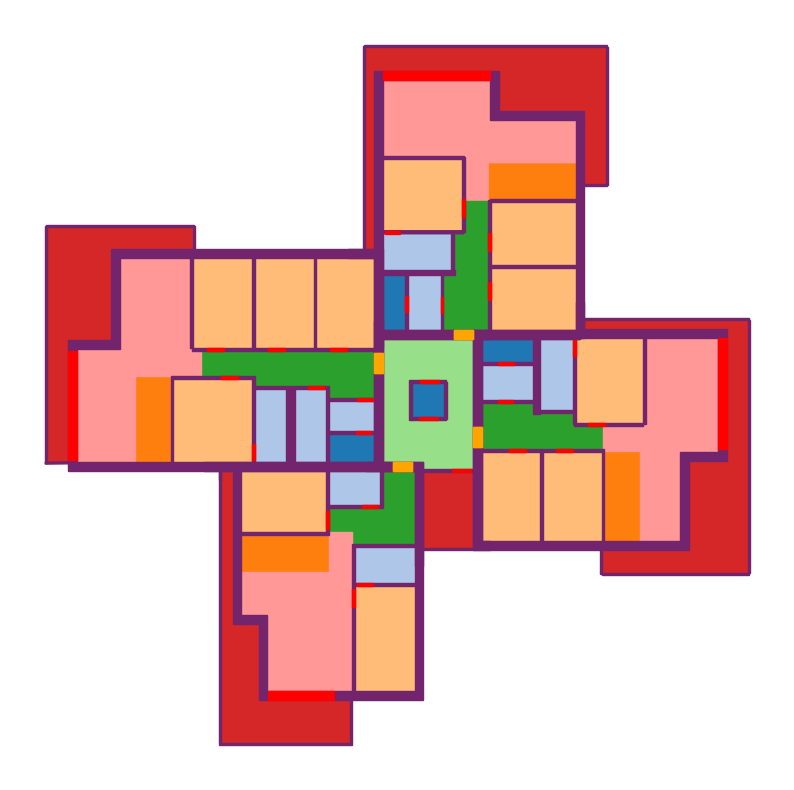

In [128]:
from plot import plot_floorplan, FS
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(FS, FS))
# fig.set_facecolor('black')
# ax.set_facecolor('black')
colorset = 'tab20'
_ = ax.axis('off')

plot_floorplan(ax, areas, area_types, doors=[doors, front_doors], walls=walls, linewidth=FS / 10, colorset=colorset, classes=SUBTYPES_NAMES)

The following function extracts the 'access' graph from the corresponding geometric information.

We found out that the best way to save polygons in a graph is using lists - instead of arrays or tensors. The latter is faster, but networkx stacks arrays when they have the same size (obviously). Since we work with variable length attributes (the polygons), NetworkX stacks the arrays sometimes (if coincidentally the arrays are of the same size, which is often the case for doors) while at other times it creates a list of arrays. This is detrimental for batch loading, since the formats are *not* consistent across all data instances. We solve this issue therefore by converting every polygon to fixed-size

In [13]:
from shapely.geometry import Polygon
import numpy as np
import torch
import networkx as nx
from itertools import combinations

# helper functions
def polygon_to_list(polygon: Polygon) -> list:
    return list(zip(*polygon.exterior.coords.xy))

def polygon_to_array(polygon: Polygon) -> np.array:
    return np.array(polygon_to_list(polygon))

# access graph extraction
def get_access_graph(areas, area_types, doors, front_doors, walls):

    # NODES
    area_nodes = {}
    for key, (area, area_type) in enumerate(zip(areas, area_types)):
        area_nodes[key] = {
            'geometry': polygon_to_list(area),
            'category': area_type,
            'centroid': torch.tensor(np.array([area.centroid.x, area.centroid.y]))
        }

    # EDGES
    edges = []
    for (i, v1), (j, v2) in combinations(enumerate(areas), 2):

        # Option 1: PASSAGE (direct access := no wall in between)
        if v1.distance(v2) < 0.04:
            edges.append([i, j, {'connectivity': 'passage', 'door_geometry': []}])

        # TODO: make [2, 3] more efficient; now it performs similar operations multiple times
        #   e.g., by computing door-room relations before the loop

        # Option 2: DOOR
        else:
            for door in doors:
                if door.distance(v1) < 0.05 and door.distance(v2) < 0.05:
                    edges.append([i, j, {'connectivity': 'door', 'door_geometry': polygon_to_list(door)}])
                else: continue

        # Option 3: FRONT DOOR
        for front_door in front_doors:
            if front_door.distance(v1) < 0.05 and front_door.distance(v2) < 0.05:
                edges.append([i, j, {'connectivity': 'entrance', 'door_geometry': polygon_to_list(front_door)}])
            else: continue

    # GRAPH
    walls = [polygon_to_list(wall) for wall in walls]
    graph = nx.Graph(walls = walls)
    graph.add_nodes_from([(u, v) for u, v in area_nodes.items()])
    graph.add_edges_from(edges)

    return graph

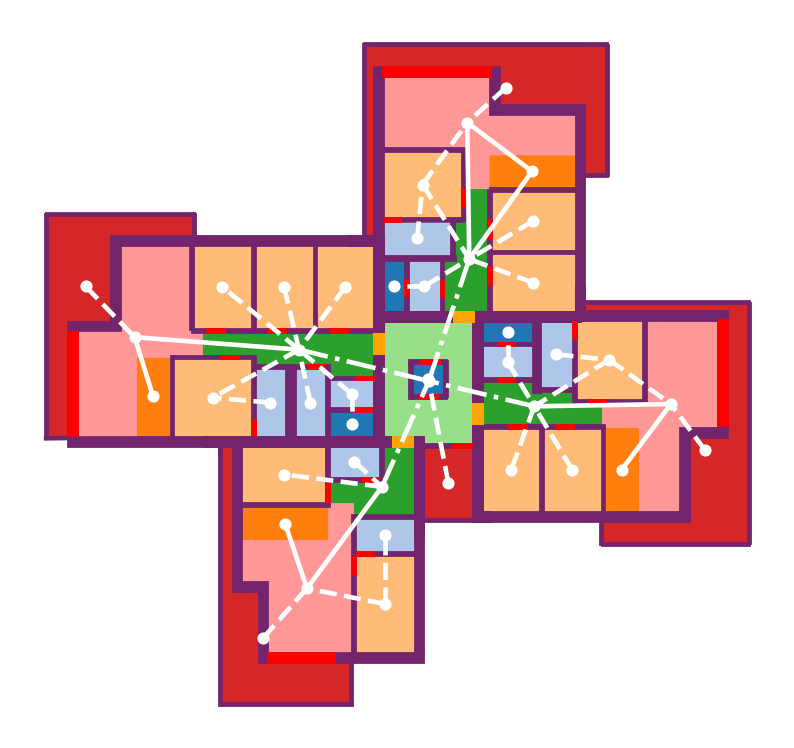

In [129]:
from plot import plot_graph
from matplotlib.cm import get_cmap

# get graph
graph = get_access_graph(areas, area_types, doors, front_doors, walls)

# figure
# setting
fig, ax = plt.subplots(1, 1, figsize=(FS, FS))
# fig.set_facecolor('black')
cmap = get_cmap(colorset)
edge_colors = ['white']*4
_ = [ax.axis('off'), ax.axes.set_aspect('equal')]

# geometry
plot_floorplan(ax, areas, area_types, walls=walls, doors=[doors, front_doors], linewidth=FS/5, colorset=colorset)

# graph
pos = {n: np.array(graph.nodes[n]['centroid']) for n in graph.nodes}
colors = [np.array(cmap(SUBTYPES_NAMES.index(n))).reshape(1,4) for _, n in graph.nodes('category')]
plot_graph(graph, ax, c_node='white', dw_edge=True, c_edge=edge_colors, pos=pos, node_size=FS*6, edge_size=FS/3)

## Develop dataset

In [ ]:
import torch_geometric as pyg
from tqdm.auto import tqdm

# helper functions
def get_max_size_polygon(areas):

    max_points = 0
    for area in areas:
        temp_points = len(polygon_to_list(area))-1
        if temp_points > max_points:
            max_points = temp_points

    return max_points


stop = 0
save = 'real'

max_points = 0
for floor_id in tqdm(list(correct_floor_ids)):

    path_graph = os.path.join(path, 'graphs', f'{floor_id}.pickle')
    # if os.path.exists(path_graph): continue  # don't do the same computation twice

    # get geometry information
    floor_geoms_df = floor_geometries_from_id(correct_geometries, floor_id)
    areas, area_types, doors, front_doors, walls = get_geometries_from_frame(floor_geoms_df)

    temp_points = get_max_size_polygon(areas)
    if temp_points > max_points:
        max_points = temp_points
        print(f'Current biggest polygon: {max_points}')

        # fig, ax = plt.subplots(1, 1, figsize=(FS, FS))
        # fig.set_facecolor('black')
        # plot_floorplan(ax, areas, area_types, walls=walls, doors=[doors, front_doors], linewidth=FS/5, colorset=colorset, marker='o')

    # access graph extraction
    graph = get_access_graph(areas, area_types, doors, front_doors, walls)
    graph_pyg = pyg.utils.from_networkx(graph)

    if save == 'dummy': torch.save(graph_pyg, os.path.join(r'./dump/graph-data-examples', f'{floor_id}.pickle'))
    else: torch.save(graph_pyg, os.path.join(path, 'graphs', f'{floor_id}.pickle'))

    stop += 1
    if stop == 20 and save == 'dummy': break
    # if stop == 50: break

  0%|          | 0/13451 [00:00<?, ?it/s]

Current biggest polygon: 24
Current biggest polygon: 40
Current biggest polygon: 85
Current biggest polygon: 87
Current biggest polygon: 143
Current biggest polygon: 154
Current biggest polygon: 275


## Dataloader

The data is small enough to use an in-memory dataloader (see pytorch geometric documentation). Simply, the whole dataset is loaded at once in RAM and

### Import graph data

In [123]:
floor_id = 46637

# helper function(s)
def nx_to_pyg(graph_pyg, graph_attrs=["walls"], node_attrs=["geometry", "centroid", "category"], edge_attrs=["connectivity", "door_geometry"]):
    return pyg.utils.to_networkx(graph_pyg, to_undirected=True, graph_attrs=graph_attrs, node_attrs=node_attrs, edge_attrs=edge_attrs)

# graph for info (pytorch geometric)
graph_pyg = torch.load(os.path.join(path, 'graphs', f'{floor_id}.pickle'))
print(f"Pytorch Geometric Data() instance:\n\t{graph_pyg}\n")

# graph for viz (networkx)
graph_nx = nx_to_pyg(graph_pyg)
print(f"NetworkX Graph() instance:\n\t{graph_nx}")

Pytorch Geometric Data() instance:
	Data(edge_index=[2, 90], geometry=[43], category=[43], centroid=[43, 2], connectivity=[90], door_geometry=[90], walls=[97, 5, 2], num_nodes=43)

NetworkX Graph() instance:
	Graph with 43 nodes and 45 edges


### Visualize floor plan

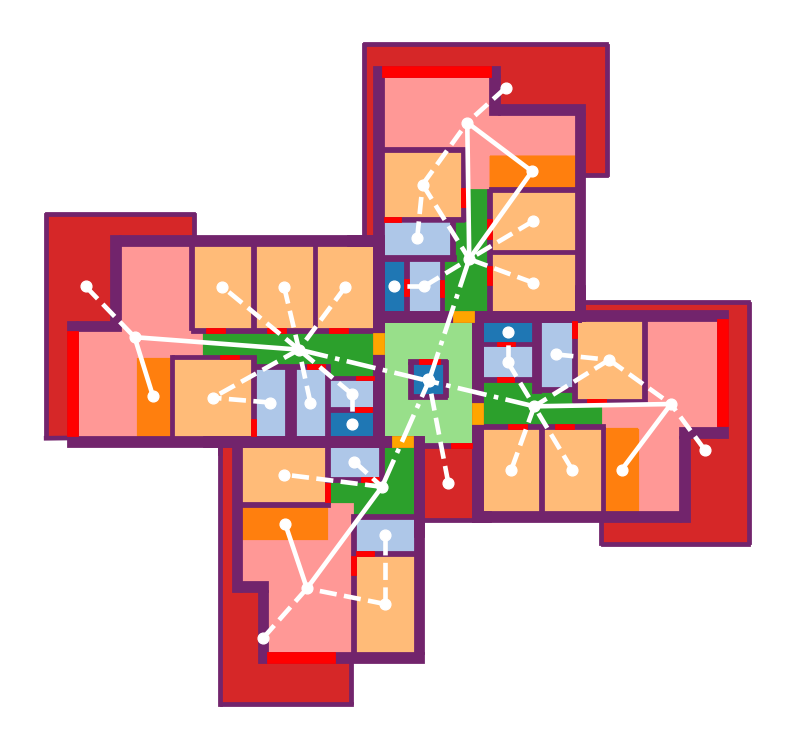

In [124]:
# helper function(s)
def extract_info_nx(graph_nx):

    """
    Functions that extracts list of attributes in the right format from a NetworkX graph.
    """

    g_walls = [Polygon(n) for n in graph_nx.graph["walls"]]

    x_geom = [Polygon(n) for _,n in graph_nx.nodes("geometry")]
    x_cat = [n for _, n in graph_nx.nodes("category")]
    x_pos = {n: np.array(graph_nx.nodes[n]["centroid"]) for n in graph_nx.nodes}
    x_colors = [np.array(cmap(SUBTYPES_NAMES.index(n))).reshape(1,4) for n in x_cat]

    e_doors = [Polygon(v["door_geometry"]) for _, _, v in graph_nx.edges(data=True) if v["connectivity"] == 'door']
    e_front = [Polygon(v["door_geometry"]) for _, _, v in graph_nx.edges(data=True) if v["connectivity"] == 'entrance']

    return g_walls, x_geom, x_cat, x_pos, x_colors, e_doors, e_front

# // Extract walls, areas, area types, etc.
walls, areas, area_types, pos, colors, doors, front_doors = extract_info_nx(graph_nx)

# // Plot
# setting
fig, ax = plt.subplots(1, 1, figsize=(FS, FS))
# fig.set_facecolor('black')
cmap = get_cmap(colorset)
edge_colors = ['white']*4
_ = [ax.axis('off'), ax.axes.set_aspect('equal')]

# geometry
plot_floorplan(ax, areas, area_types, walls=walls, doors=[doors, front_doors], linewidth=FS/5, colorset=colorset)

# graph
plot_graph(graph_nx, ax, c_node='white', dw_edge=True, c_edge=edge_colors, pos=pos, node_size=FS*6, edge_size=FS/3)

### Plot a bunch

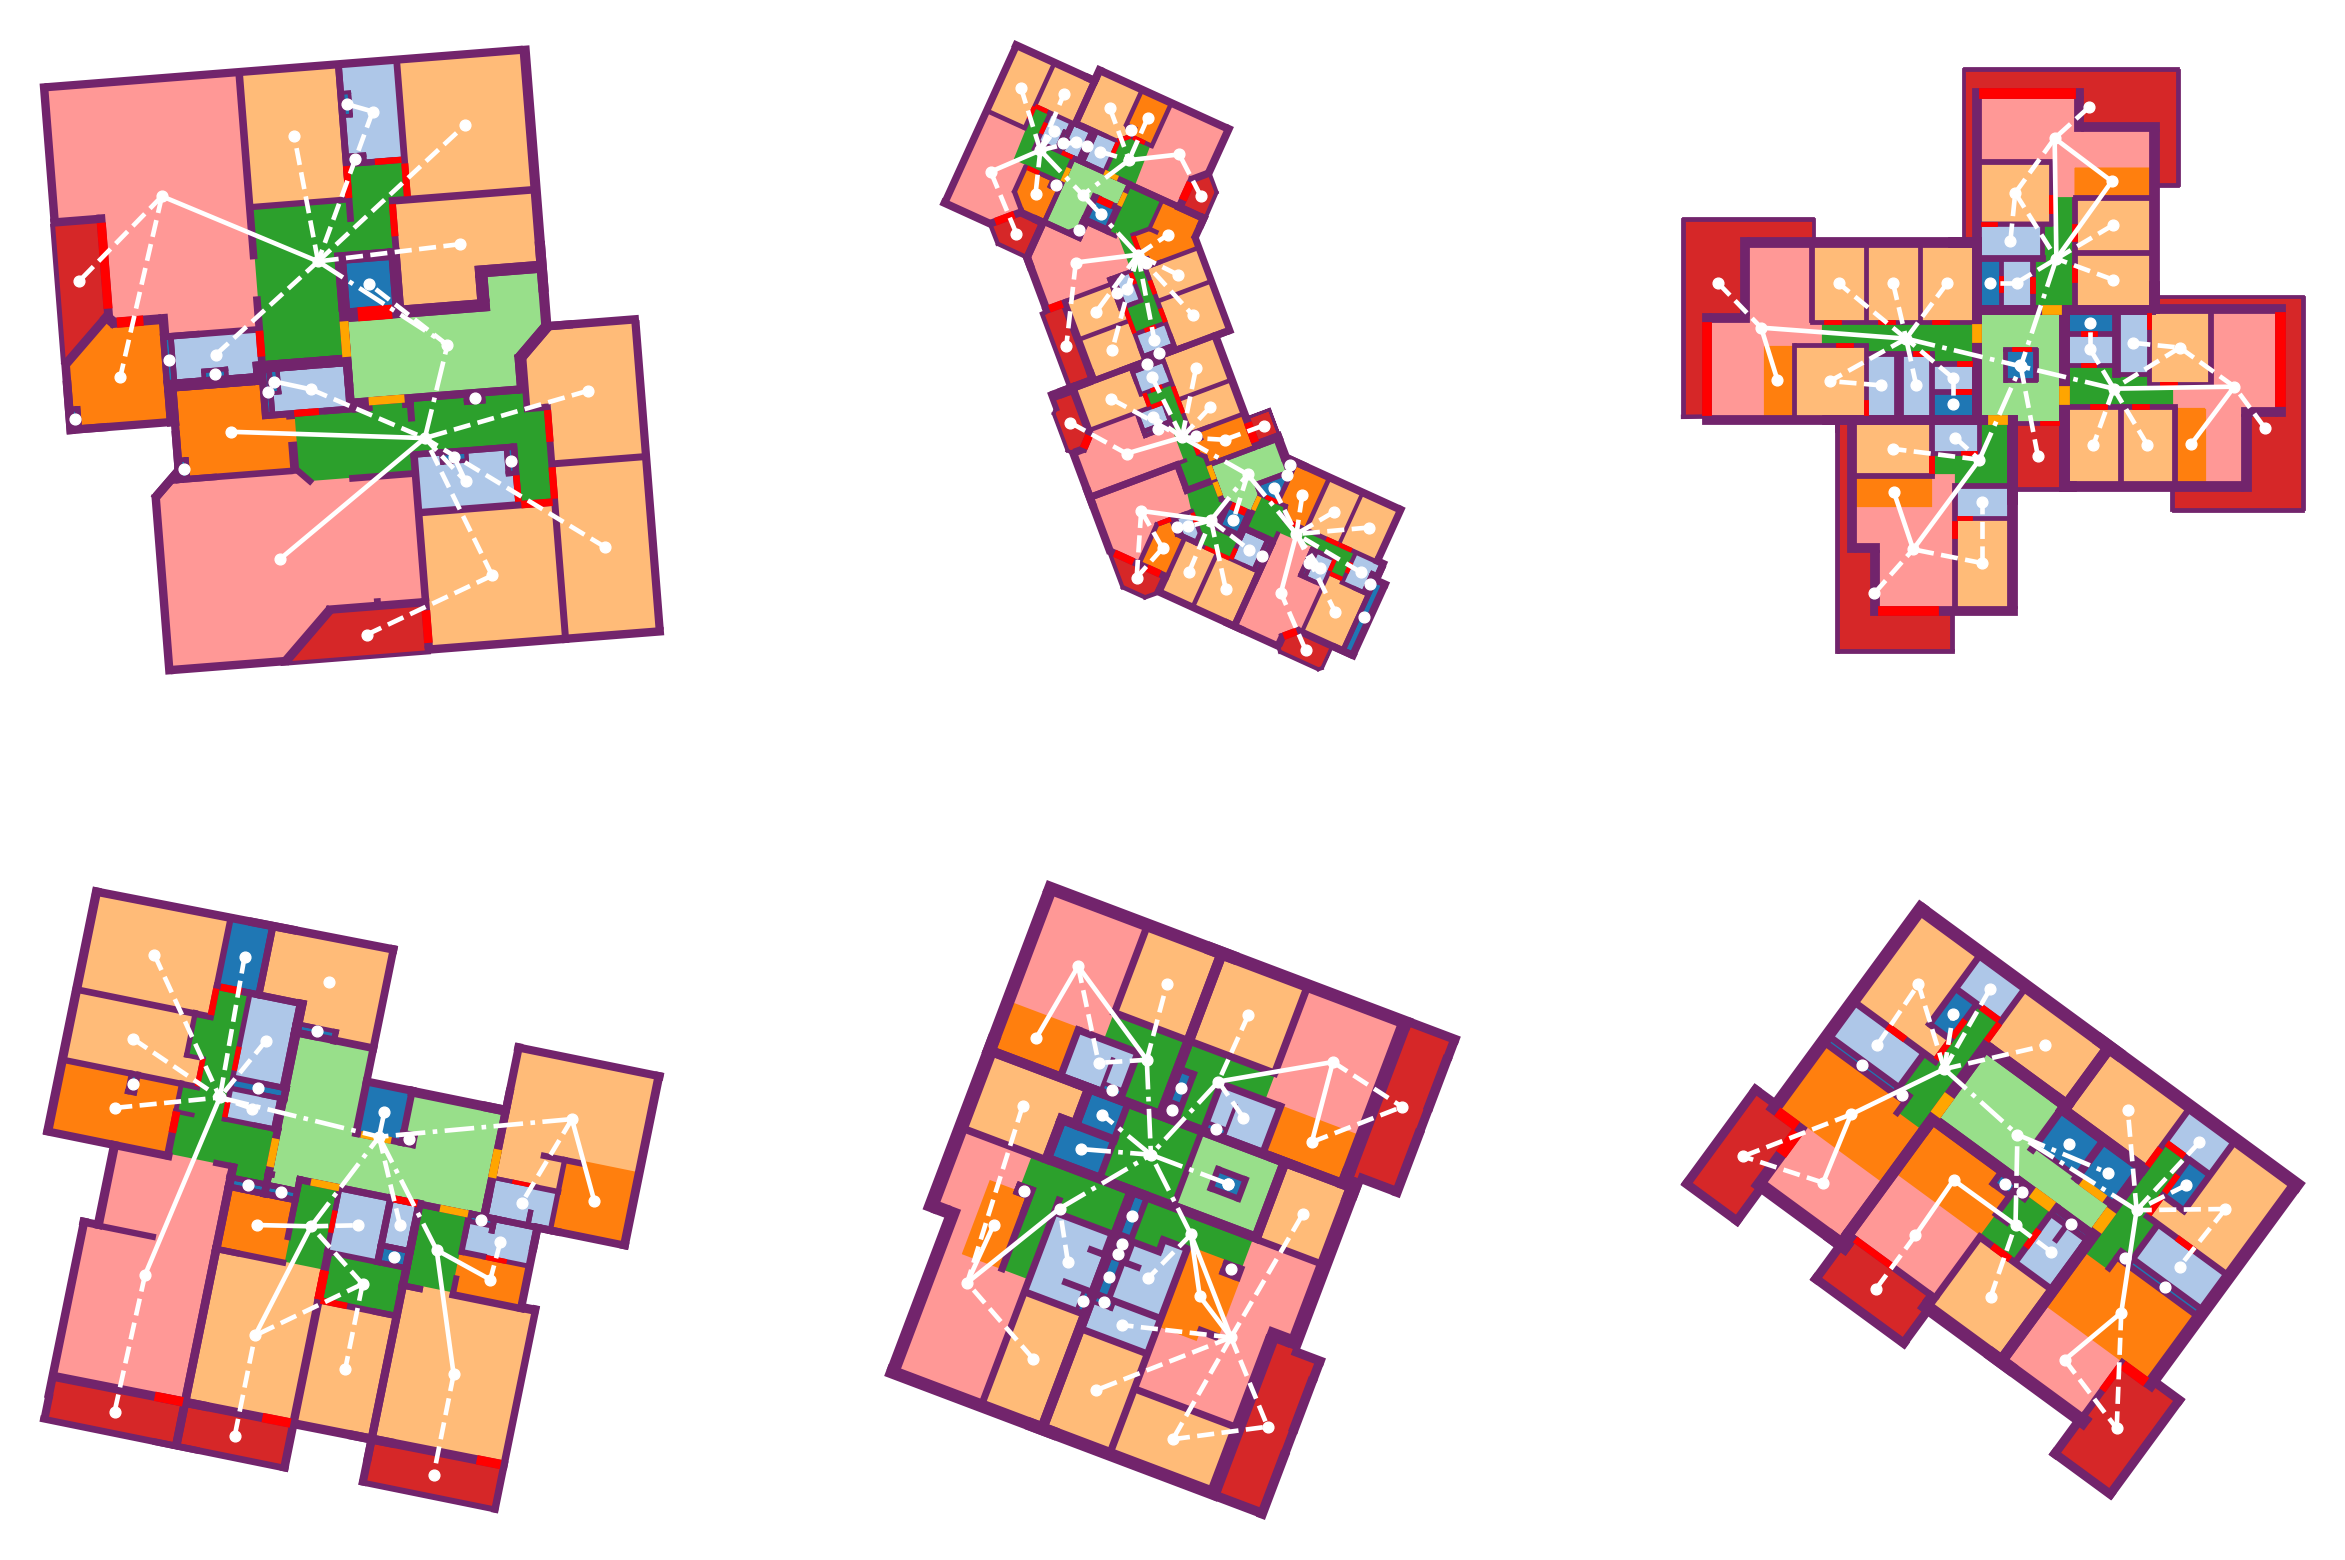

In [120]:
# setting
fig, axs = plt.subplots(2, 3, figsize=(FS*3, FS*2))
axs = axs.flatten()
# fig.set_facecolor('black')
cmap = get_cmap(colorset)
edge_colors = ['white']*4

for i, floor_id in enumerate([87, 118, 46637, 132, 13042, 13052]):

    # set axis
    ax = axs[i]
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    # load graph
    graph_pyg = torch.load(os.path.join(path, 'graphs', f'{floor_id}.pickle'))
    graph_nx = nx_to_pyg(graph_pyg)

    # extract walls, areas, area types, etc.
    walls, areas, area_types, pos, colors, doors, front_doors = extract_info_nx(graph_nx)

    # geometry
    plot_floorplan(ax, areas, area_types, walls=walls, doors=[doors, front_doors], linewidth=FS/5, colorset=colorset)
    plot_graph(graph_nx, ax, c_node='white', dw_edge=True, c_edge=edge_colors, pos=pos, node_size=FS*6, edge_size=FS/3)

### Load dataset (pytorch) and dataloader (pytorch geometric)

Randomly shuffle for training and test set curation

In [80]:
"""
Remove 1. small apartments that do not have connections,
and 2. have only a very small amount of areas.
"""

floor_ids_no_connect = []

for floor_id in tqdm(correct_floor_ids):
    graph_path = os.path.join(path, 'graphs')
    graph_pyg = torch.load(os.path.join(graph_path, f'{floor_id}.pickle'))

    # first: check whether there are any connections
    try: graph_pyg.connectivity
    except:
        print(f'CONNECTION //\t{floor_id}: {graph_pyg}')
        floor_ids_no_connect.append(floor_id)

    # second: check whether geometry is saved as lists
    try:
        graph_pyg.geometry.size
        print(f'SIZE //\t\t{floor_id}: {graph_pyg}')
        floor_ids_no_connect.append(floor_id)
    except:
        continue

  0%|          | 0/13451 [00:00<?, ?it/s]

CONNECTION //	2036: Data(edge_index=[2, 0], geometry=[2], category=[2], centroid=[2, 2], walls=[12, 5, 2], num_nodes=2)
CONNECTION //	2040: Data(edge_index=[2, 0], geometry=[1, 13, 2], category=[1], centroid=[1, 2], walls=[10, 5, 2], num_nodes=1)
SIZE //		2040: Data(edge_index=[2, 0], geometry=[1, 13, 2], category=[1], centroid=[1, 2], walls=[10, 5, 2], num_nodes=1)
CONNECTION //	2736: Data(edge_index=[2, 0], geometry=[3], category=[3], centroid=[3, 2], walls=[21, 5, 2], num_nodes=3)
CONNECTION //	40479: Data(edge_index=[2, 0], geometry=[1, 13, 2], category=[1], centroid=[1, 2], walls=[13, 5, 2], num_nodes=1)
SIZE //		40479: Data(edge_index=[2, 0], geometry=[1, 13, 2], category=[1], centroid=[1, 2], walls=[13, 5, 2], num_nodes=1)
CONNECTION //	9280: Data(edge_index=[2, 0], geometry=[5], category=[5], centroid=[5, 2], walls=[35], num_nodes=5)
CONNECTION //	11527: Data(edge_index=[2, 0], geometry=[1, 34, 2], category=[1], centroid=[1, 2], walls=[20, 5, 2], num_nodes=1)
SIZE //		11527: Da

In [81]:
print(len(floor_ids_no_connect))

56


In [95]:
import random

# create temporarily ids list from original in order to not shuffle the original one
temp_ids = list(set(correct_floor_ids) - set(floor_ids_no_connect))
n = len(temp_ids)
random.Random(4).shuffle(temp_ids)
split = 0.7

# training length
nt = int(split*n)
if (n - nt) % 2 == 1: nt += 1 # add one if odd number

# validation and test length
nv = int((n - nt)/2)

print(f"Total:\t{n}")
print(f'Samples:\n\ttrain:\t{nt}\n\tval:\t{nv}\n\ttest:\t{nv}')

correct_ids = {
    "train": np.sort(temp_ids[:nt]),
    "val": np.sort(temp_ids[nt:nt+nv]),
    "test": np.sort(temp_ids[nt+nv:])
}

torch.save(correct_ids, os.path.join(path, 'correct_ids.pickle'))

Total:	13409
Samples:
	train:	9387
	val:	2011
	test:	2011


### Meta analysis of geometries and connections

- distribution of number of geometries per floor
- distribution of number of edges per floor
- distribution of polygon size (number of coordinates) of whole dataset

In [100]:
n_geometries = []
n_edges = []
size_geometries = []

# print(graph_pyg.geometry)
print([len(area) for area in graph_pyg.geometry])

for floor_id in tqdm(temp_ids):
    graph_pyg = torch.load(os.path.join(graph_path, f'{floor_id}.pickle'))
    n_geometries.append(len(graph_pyg.geometry))
    n_edges.append(int(len(graph_pyg.edge_index[1])/2))
    size_geometries.extend([len(area) for area in graph_pyg.geometry])

[5, 5, 5, 5, 5, 5, 9, 5, 5, 18, 8, 5, 5, 9, 20, 5, 11, 5, 5, 7, 5, 5, 5, 13, 5, 5, 7, 5, 5, 9, 5, 13, 9, 5, 5]


  0%|          | 0/13409 [00:00<?, ?it/s]

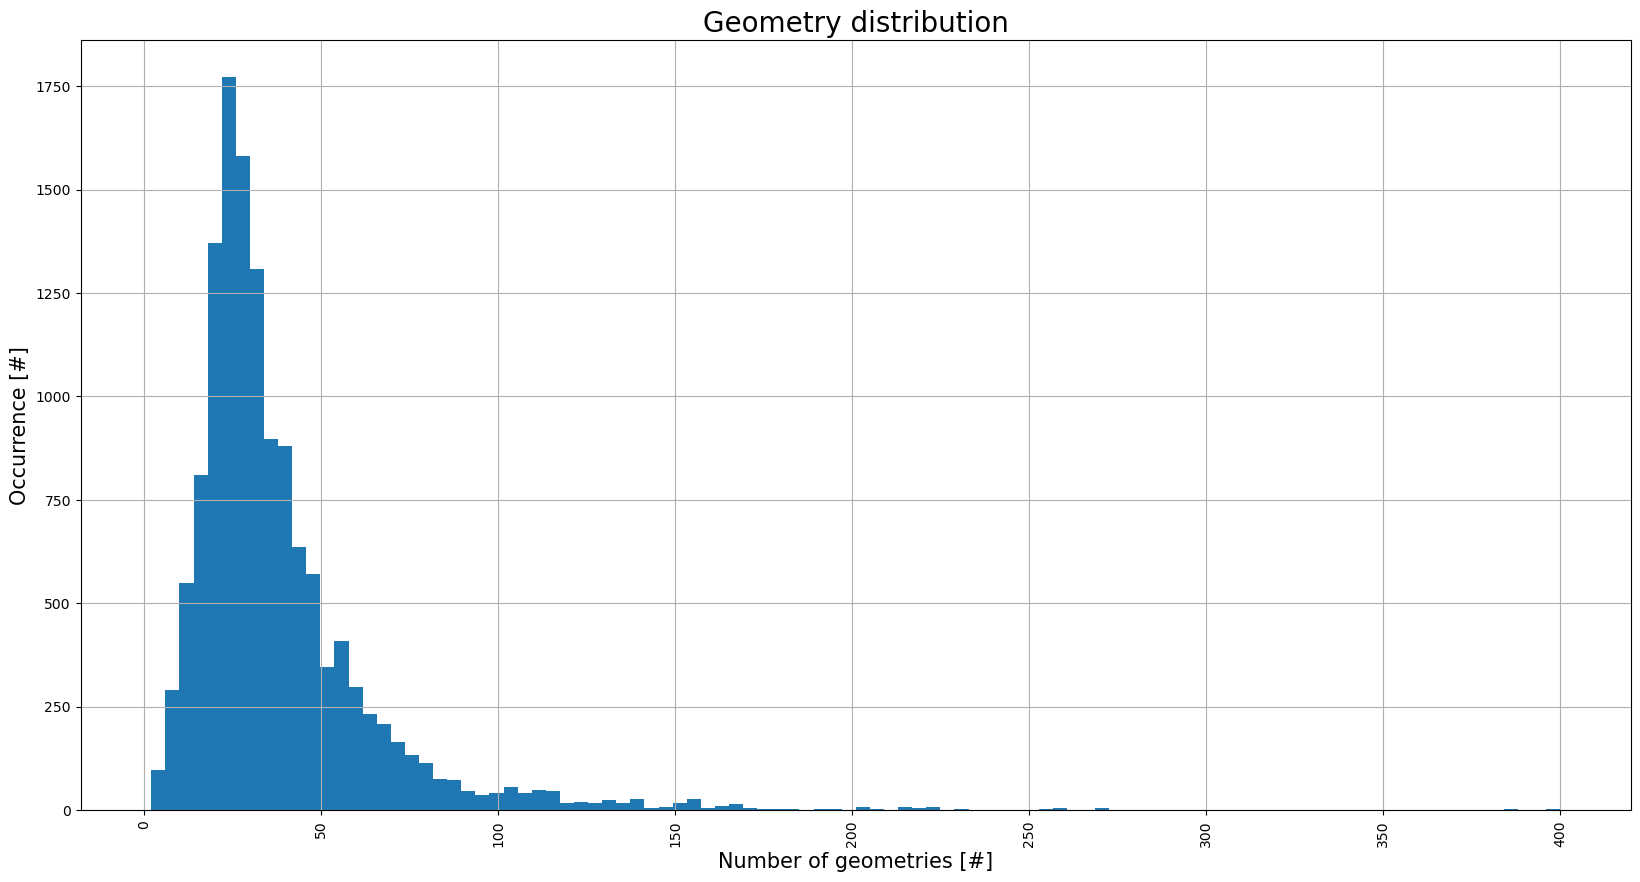

In [121]:
FS = 10
fig, ax = plt.subplots(1,1,figsize=(FS*2, FS))
ax.grid(True)

ax.hist(n_geometries, bins=100)
# ax.set_yscale('log') # set to log-scale for interpretability
ax.tick_params(axis='x', labelrotation = 90)
_ = ax.set_ylabel('Occurrence [#]', fontsize=15)
_ = ax.set_xlabel('Number of geometries [#]', fontsize=15)
_ = ax.set_title('Geometry distribution', fontsize=20)

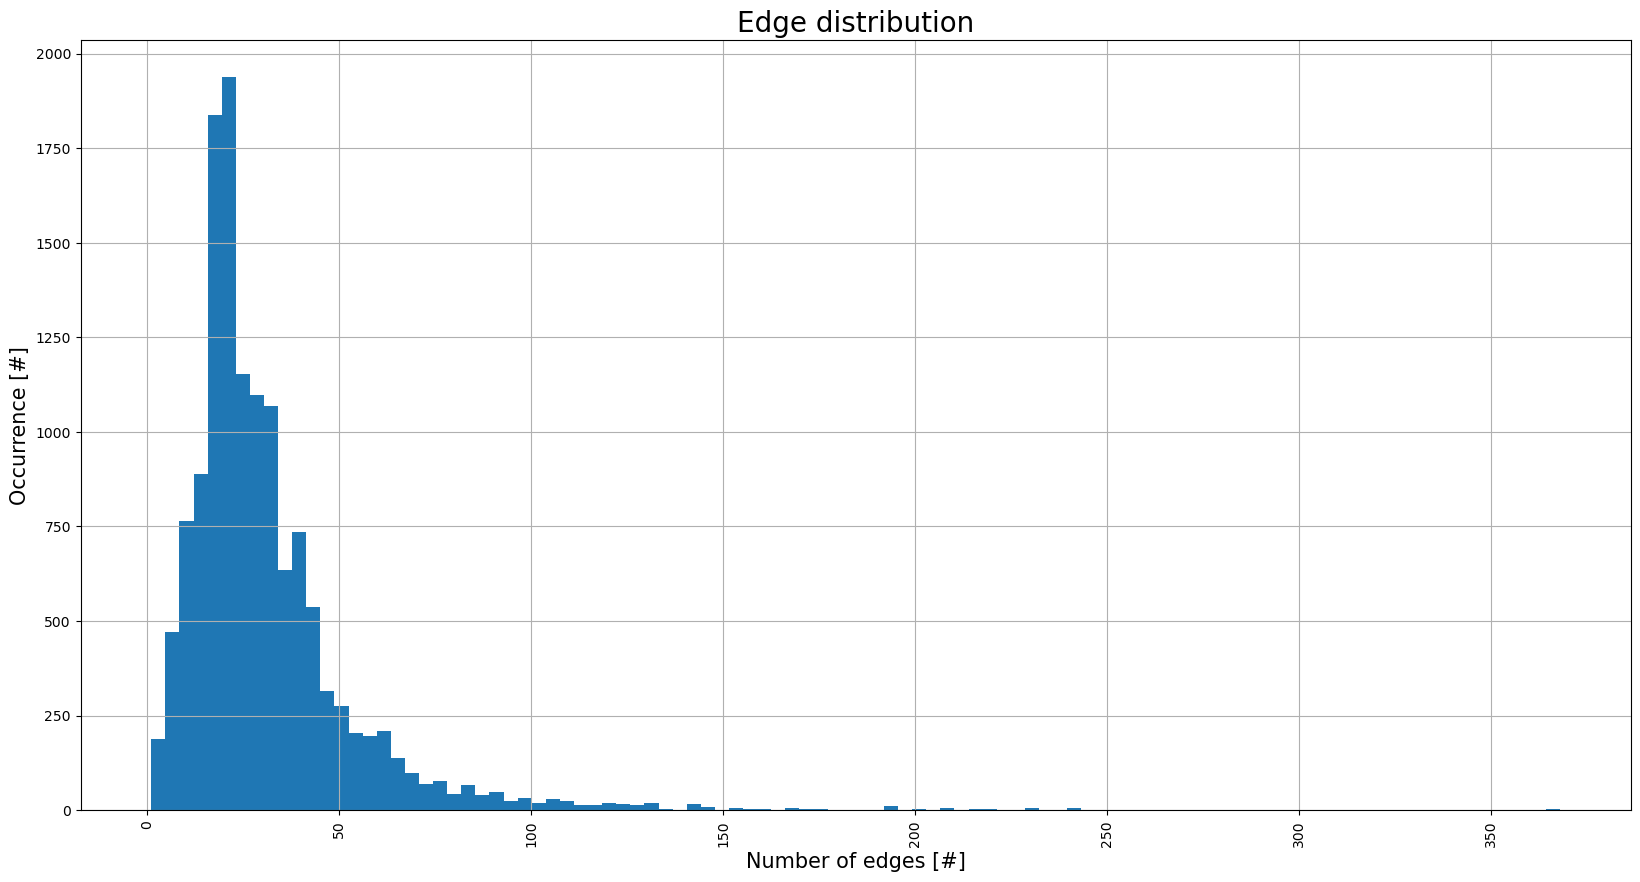

In [122]:
FS = 10
fig, ax = plt.subplots(1,1,figsize=(FS*2, FS))
ax.grid(True)

ax.hist(n_edges, bins=100)
# ax.set_yscale('log') # set to log-scale for interpretability
ax.tick_params(axis='x', labelrotation = 90)
_ = ax.set_ylabel('Occurrence [#]', fontsize=15)
_ = ax.set_xlabel('Number of edges [#]', fontsize=15)
_ = ax.set_title('Edge distribution', fontsize=20)

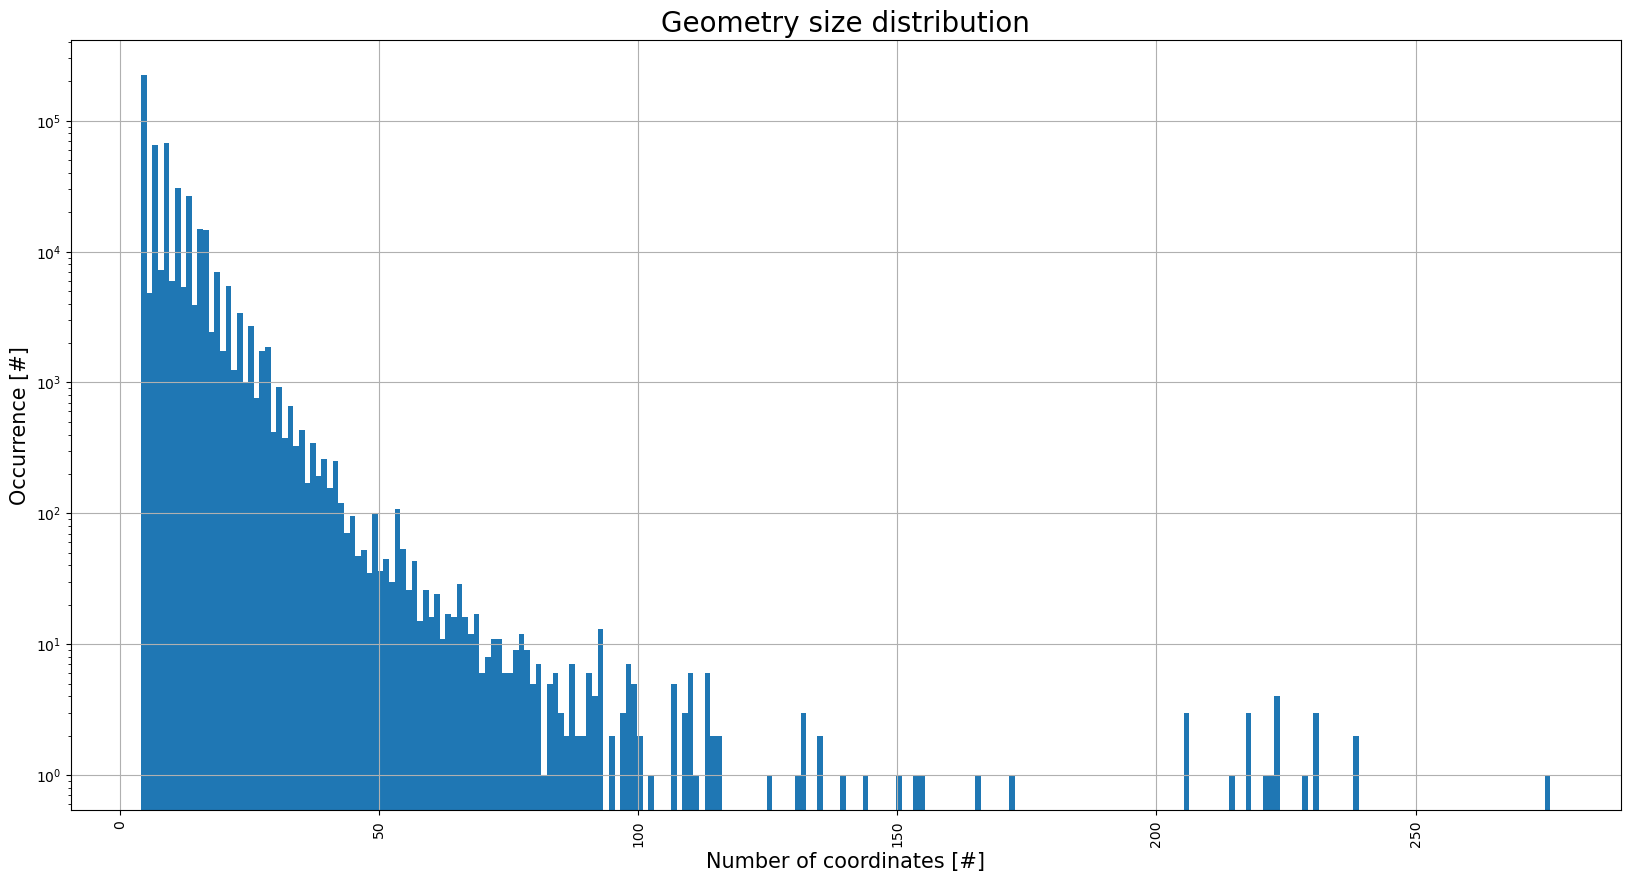

In [115]:
FS = 10
fig, ax = plt.subplots(1,1,figsize=(FS*2, FS))
ax.grid(True)

ax.hist(size_geometries, bins=250)
ax.set_yscale('log') # set to log-scale for interpretability
ax.tick_params(axis='x', labelrotation = 90)
_ = ax.set_ylabel('Occurrence [#]', fontsize=15)
_ = ax.set_xlabel('Number of coordinates [#]', fontsize=15)
_ = ax.set_title('Geometry size distribution', fontsize=20)

### Develop dataloader and check it

In [83]:
# helper function(s)
def extract_info_pyg(graph_pyg):

    x_cat = graph_pyg.category
    y_geom = graph_pyg.geometry
    edge_index = graph_pyg.edge_index

    return x_cat, y_geom, edge_index


# dataset and dataloader
class PolyGraphDataset(torch.utils.data.Dataset):
    def __init__(self, path, mode='train'):
        self.graph_path = os.path.join(path, 'graphs')
        self.correct_ids = torch.load(os.path.join(path, f'correct_ids.pickle'))[mode]

        # TODO: include graph transformations if necessary
        # self.graph_transform = graph_transform

    def __getitem__(self, index):

        # get floor plan identity
        floor_id = self.correct_ids[index]

        # get graph
        graph_pyg = torch.load(os.path.join(self.graph_path, f'{floor_id}.pickle'))
        del graph_pyg.walls
        del graph_pyg.door_geometry

        return graph_pyg

    def __len__(self):
        return len(self.correct_ids)

In [87]:
bs = 64
dataset = PolyGraphDataset(path, mode='train')
sampler = None  # no distributed training for now
dataloader = pyg.loader.DataLoader(dataset, batch_size=bs, shuffle=(sampler is None), sampler=sampler)
n_batches = len(dataloader)
print(f'Length dataloader (bs={bs}): {n_batches}')

Length dataloader (bs=64): 147


In [89]:
dataiter = iter(dataloader)

for _ in tqdm(range(n_batches)):
    try:
        batch = next(dataiter)
        print(batch)
    except:
        break

DataBatch(edge_index=[2, 4150], geometry=[64], category=[64], centroid=[2506, 2], connectivity=[64], num_nodes=2506, batch=[2506], ptr=[65])
DataBatch(edge_index=[2, 4836], geometry=[64], category=[64], centroid=[2878, 2], connectivity=[64], num_nodes=2878, batch=[2878], ptr=[65])
DataBatch(edge_index=[2, 4074], geometry=[64], category=[64], centroid=[2524, 2], connectivity=[64], num_nodes=2524, batch=[2524], ptr=[65])
DataBatch(edge_index=[2, 4218], geometry=[64], category=[64], centroid=[2543, 2], connectivity=[64], num_nodes=2543, batch=[2543], ptr=[65])
DataBatch(edge_index=[2, 3912], geometry=[64], category=[64], centroid=[2328, 2], connectivity=[64], num_nodes=2328, batch=[2328], ptr=[65])
DataBatch(edge_index=[2, 3972], geometry=[64], category=[64], centroid=[2415, 2], connectivity=[64], num_nodes=2415, batch=[2415], ptr=[65])
DataBatch(edge_index=[2, 3980], geometry=[64], category=[64], centroid=[2404, 2], connectivity=[64], num_nodes=2404, batch=[2404], ptr=[65])
DataBatch(edg

Check a batch

In [94]:
dataiter = iter(dataloader)
batch = next(dataiter)

# print length of first instance in batch (geometry)
print(len(batch.geometry[0]))

22
